In [1]:
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import zarr
import collections


import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork
from utils.clip import load_clip
import einops
import torch.nn as nn
import torch.nn.functional as F
from utils.layers import RelativeCrossAttentionModule
from models.conditional_unet1d import ConditionalUnet1D
from utils.position_encodings import SinusoidalPosEmb
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from utils.position_encodings import RotaryPositionEncoding, RotaryPositionEncoding3D, RotaryPositionEncoding2D
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt

# env import
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os


/home/felix/miniforge3/envs/tshape/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::

    y
    ^
    |      . (3, 3)
    |
    |   . (2, 2)
    |
    +------ > x

When False::

    +------ > x
    |
    |   . (2, 2)
    |
    |      . (3, 3)
    v
    y

"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

class DrawOptions(pymunk.SpaceDebugDrawOptions):
    def __init__(self, surface: pygame.Surface) -> None:
        """Draw a pymunk.Space on a pygame.Surface object.

        Typical usage::

        >>> import pymunk
        >>> surface = pygame.Surface((10,10))
        >>> space = pymunk.Space()
        >>> options = pymunk.pygame_util.DrawOptions(surface)
        >>> space.debug_draw(options)

        You can control the color of a shape by setting shape.color to the color
        you want it drawn in::

        >>> c = pymunk.Circle(None, 10)
        >>> c.color = pygame.Color("pink")

        See pygame_util.demo.py for a full example

        Since pygame uses a coordiante system where y points down (in contrast
        to many other cases), you either have to make the physics simulation
        with Pymunk also behave in that way, or flip everything when you draw.

        The easiest is probably to just make the simulation behave the same
        way as Pygame does. In that way all coordinates used are in the same
        orientation and easy to reason about::

        >>> space = pymunk.Space()
        >>> space.gravity = (0, -1000)
        >>> body = pymunk.Body()
        >>> body.position = (0, 0) # will be positioned in the top left corner
        >>> space.debug_draw(options)

        To flip the drawing its possible to set the module property
        :py:data:`positive_y_is_up` to True. Then the pygame drawing will flip
        the simulation upside down before drawing::

        >>> positive_y_is_up = True
        >>> body = pymunk.Body()
        >>> body.position = (0, 0)
        >>> # Body will be position in bottom left corner

        :Parameters:
                surface : pygame.Surface
                    Surface that the objects will be drawn on
        """
        self.surface = surface
        super(DrawOptions, self).__init__()

    def draw_circle(
        self,
        pos: Vec2d,
        angle: float,
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p = to_pygame(pos, self.surface)

        pygame.draw.circle(self.surface, fill_color.as_int(), p, round(radius), 0)
        pygame.draw.circle(self.surface, light_color(fill_color).as_int(), p, round(radius-4), 0)

        circle_edge = pos + Vec2d(radius, 0).rotated(angle)
        p2 = to_pygame(circle_edge, self.surface)
        line_r = 2 if radius > 20 else 1
        # pygame.draw.lines(self.surface, outline_color.as_int(), False, [p, p2], line_r)

    def draw_segment(self, a: Vec2d, b: Vec2d, color: SpaceDebugColor) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        pygame.draw.aalines(self.surface, color.as_int(), False, [p1, p2])

    def draw_fat_segment(
        self,
        a: Tuple[float, float],
        b: Tuple[float, float],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        r = round(max(1, radius * 2))
        pygame.draw.lines(self.surface, fill_color.as_int(), False, [p1, p2], r)
        if r > 2:
            orthog = [abs(p2[1] - p1[1]), abs(p2[0] - p1[0])]
            if orthog[0] == 0 and orthog[1] == 0:
                return
            scale = radius / (orthog[0] * orthog[0] + orthog[1] * orthog[1]) ** 0.5
            orthog[0] = round(orthog[0] * scale)
            orthog[1] = round(orthog[1] * scale)
            points = [
                (p1[0] - orthog[0], p1[1] - orthog[1]),
                (p1[0] + orthog[0], p1[1] + orthog[1]),
                (p2[0] + orthog[0], p2[1] + orthog[1]),
                (p2[0] - orthog[0], p2[1] - orthog[1]),
            ]
            pygame.draw.polygon(self.surface, fill_color.as_int(), points)
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p1[0]), round(p1[1])),
                round(radius),
            )
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p2[0]), round(p2[1])),
                round(radius),
            )

    def draw_polygon(
        self,
        verts: Sequence[Tuple[float, float]],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        ps = [to_pygame(v, self.surface) for v in verts]
        ps += [ps[0]]

        radius = 2
        pygame.draw.polygon(self.surface, light_color(fill_color).as_int(), ps)

        if radius > 0:
            for i in range(len(verts)):
                a = verts[i]
                b = verts[(i + 1) % len(verts)]
                self.draw_fat_segment(a, b, radius, fill_color, fill_color)

    def draw_dot(
        self, size: float, pos: Tuple[float, float], color: SpaceDebugColor
    ) -> None:
        p = to_pygame(pos, self.surface)
        pygame.draw.circle(self.surface, color.as_int(), p, round(size), 0)


def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        elif isinstance(shape, pymunk.shapes.Circle):
            center = body.position
            geoms.append(sg.Point(center).buffer(shape.radius))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

# env
class PushTEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0., 1.)

    def __init__(self,
            legacy=False,
            block_cog=None, damping=None,
            render_action=True,
            render_size=96,
            reset_to_state=None
        ):
        self._seed = None
        self.seed()
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        # Local controller params.
        self.k_p, self.k_v = 100, 20    # PD control.z
        self.control_hz = self.metadata['video.frames_per_second']
        # legcay set_state for data compatiblity
        self.legacy = legacy

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0], dtype=np.float64),
            high=np.array([ws,ws,ws,ws,np.pi*2], dtype=np.float64),
            shape=(5,),
            dtype=np.float64
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0,0], dtype=np.float64),
            high=np.array([ws,ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    def reset(self):
        seed = self._seed
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatiblity
        state = self.reset_to_state
        if state is None:
            rs = np.random.RandomState(seed=seed)
            state = np.array([
                rs.randint(50, 450), rs.randint(50, 450),
                rs.randint(100, 400), rs.randint(100, 400),
                rs.randn() * 2 * np.pi - np.pi
                ])
        self._set_state(state)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (Vec2d(0, 0) - self.agent.velocity)
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0, 1)
        done = coverage > self.success_threshold
        terminated = done
        truncated = done

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self, mode):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple('TeleopAgent', ['act'])
        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(Vec2d(*pygame.mouse.get_pos()), self.screen)
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act
        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position) \
            + tuple(self.block.position) \
            + (self.block.angle % (2 * np.pi),))
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here dosn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            'pos_agent': np.array(self.agent.position),
            'vel_agent': np.array(self.agent.velocity),
            'block_pose': np.array(list(self.block.position) + [self.block.angle]),
            'goal_pose': self.goal_pose,
            'n_contacts': n_contact_points_per_step}
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)

        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is aleady ticked during in step for "human"


        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / 512 * 96).astype(np.int32)
                marker_size = int(8/96*self.render_size)
                thickness = int(1/96*self.render_size)
                cv2.drawMarker(img, coord,
                    color=(255,0,0), markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size, thickness=thickness)
        return img


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0,25536)
        self._seed = seed
        self.np_random = np.random.default_rng(seed)

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatiblity with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2],
            rotation=self.goal_pose[2])
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2],
            rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(
            matrix=tf_img_obj.params @ tf_obj_new.params
        )
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0]) + list(tf_img_new.translation) \
                + [tf_img_new.rotation])
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2)
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        self.block = self.add_tee((256, 300), 0)
        self.goal_color = pygame.Color('LightGreen')
        self.goal_pose = np.array([256,256,np.pi/4])  # x, y, theta (in radians)

        # Add collision handeling
        self.collision_handeler = self.space.add_collision_handler(0, 0)
        self.collision_handeler.post_solve = self._handle_collision
        self.n_contact_points = 0

        self.max_score = 50 * 100
        self.success_threshold = 0.95    # 95% coverage.

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color('LightGray')    # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color('RoyalBlue')
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color('LightSlateGray')
        self.space.add(body, shape)
        return body

    def add_tee(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices1)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body


class PushTImageEnv(PushTEnv):
    metadata = {"render.modes": ["rgb_array"], "video.frames_per_second": 10}

    def __init__(self,
            legacy=False,
            block_cog=None,
            damping=None,
            render_size=96):
        super().__init__(
            legacy=legacy,
            block_cog=block_cog,
            damping=damping,
            render_size=render_size,
            render_action=False)
        ws = self.window_size
        self.observation_space = spaces.Dict({
            'image': spaces.Box(
                low=0,
                high=1,
                shape=(3,render_size,render_size),
                dtype=np.float32
            ),
            'agent_pos': spaces.Box(
                low=0,
                high=ws,
                shape=(2,),
                dtype=np.float32
            ),
            'tee_mask': spaces.Box(
                low=0,
                high=1,
                shape=(render_size,render_size),
                dtype=np.uint8
            ),
            'goal_mask': spaces.Box(
                low=0,
                high=1,
                shape=(render_size,render_size),
                dtype=np.uint8
            ),
            'agent_mask': spaces.Box(
                low=0,
                high=1,
                shape=(render_size,render_size),
                dtype=np.uint8
            ),
            'goal_pose': spaces.Box(
                low=0,
                high=ws,
                shape=(3,),
                dtype=np.float32
            )
        })
        self.render_cache = None

    def _get_obs(self):
        img = super()._render_frame(mode='rgb_array')

        agent_pos = np.array(self.agent.position)

        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        goal_vertices = [np.array(list(polygon.exterior.coords), dtype=np.int32) for polygon in goal_geom.geoms]
        goal_mask = cv2.fillPoly(np.zeros((self.window_size, self.window_size), dtype=np.uint8), goal_vertices, 1)
        goal_mask = cv2.resize(goal_mask, (self.render_size, self.render_size))
        tee_geom = pymunk_to_shapely(self.block, self.block.shapes)
        tee_vertices = [np.array(list(polygon.exterior.coords), dtype=np.int32) for polygon in tee_geom.geoms]
        tee_mask = cv2.fillPoly(np.zeros((self.window_size, self.window_size), dtype=np.uint8), tee_vertices, 1)
        tee_mask = cv2.resize(tee_mask, (self.render_size, self.render_size))
        agent_geom = pymunk_to_shapely(self.agent, self.agent.shapes)
        agent_vertices = [np.array(list(polygon.exterior.coords), dtype=np.int32) for polygon in agent_geom.geoms]
        agent_mask = cv2.fillPoly(np.zeros((self.window_size, self.window_size), dtype=np.uint8), agent_vertices, 1)
        agent_mask = cv2.resize(agent_mask, (self.render_size, self.render_size))
        
        img_obs = np.moveaxis(img.astype(np.float32) / 255, -1, 0)
        obs = {
            'image': img_obs,
            'agent_pos': agent_pos,
            'goal_pose' : self.goal_pose,
            'tee_mask': tee_mask,
            'goal_mask': goal_mask,
            'agent_mask': agent_mask
        }

        # draw action
        if self.latest_action is not None:
            action = np.array(self.latest_action)
            coord = (action / 512 * 96).astype(np.int32)
            marker_size = int(8/96*self.render_size)
            thickness = int(1/96*self.render_size)
            cv2.drawMarker(img, coord,
                color=(255,0,0), markerType=cv2.MARKER_CROSS,
                markerSize=marker_size, thickness=thickness)
        self.render_cache = img

        return obs

    def render(self, mode):
        assert mode == 'rgb_array'

        if self.render_cache is None:
            self._get_obs()

        return self.render_cache



In [3]:
# 0. create env object
env = PushTImageEnv()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs, info = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, terminated, truncated, info = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("obs['image'].shape:", obs['image'].shape, "float32, [0,1]")
    print("obs['agent_pos'].shape:", obs['agent_pos'].shape, "float32, [0,512]")
    print("obs['goal_pose'].shape:", obs['goal_pose'].shape, "float32, [0,512]")
    print("action.shape: ", action.shape, "float32, [0,512]")
    print("obs['tee_mask'].shape:", obs['tee_mask'].shape, "uint8, {0,1}")
    print("obs['goal_mask'].shape:", obs['goal_mask'].shape, "uint8, {0,1}")
    print("obs['agent_mask'].shape:", obs['agent_mask'].shape, "uint8, {0,1}")

obs['image'].shape: (3, 96, 96) float32, [0,1]
obs['agent_pos'].shape: (2,) float32, [0,512]
obs['goal_pose'].shape: (3,) float32, [0,512]
action.shape:  (2,) float32, [0,512]
obs['tee_mask'].shape: (96, 96) uint8, {0,1}
obs['goal_mask'].shape: (96, 96) uint8, {0,1}
obs['agent_mask'].shape: (96, 96) uint8, {0,1}


In [4]:
#@markdown ### **Dataset**
#@markdown
#@markdown Defines `PushTImageDataset` and helper functions
#@markdown
#@markdown The dataset class
#@markdown - Load data ((image, agent_pos), action) from a zarr storage
#@markdown - Normalizes each dimension of agent_pos and action to [-1,1]
#@markdown - Returns
#@markdown  - All possible segments with length `pred_horizon`
#@markdown  - Pads the beginning and the end of each episode with repetition
#@markdown  - key `image`: shape (obs_hoirzon, 3, 96, 96)
#@markdown  - key `agent_pos`: shape (obs_hoirzon, 2)
#@markdown  - key `action`: shape (pred_horizon, 2)

def create_sample_indices(
        episode_ends:np.ndarray, sequence_length:int,
        pad_before: int=0, pad_after: int=0):
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

# normalize data
def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# dataset
class PushTImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_path: str,
                 pred_horizon: int,
                 obs_horizon: int,
                 action_horizon: int):

        # read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')

        # float32, [0,1], (N,96,96,3)
        train_image_data = dataset_root['data']['img'][:]
        train_image_data = np.moveaxis(train_image_data, -1,1)
        # (N,3,96,96)
        
        # (N, D)
        train_data = {
            # first two dims of state vector are agent (i.e. gripper) locations
            'agent_pos': dataset_root['data']['state'][:,:2],
            'action': dataset_root['data']['action'][:],
        }
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)
        
        # compute statistics and normalized data to [-1,1]
        stats = {
            "agent_pos": {"min": 0.0, "max": 512.0},
            "action": {"min": 0.0, "max": 512.0}
        }
        normalized_train_data = dict()
        for key, data in train_data.items():
            # stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        normalized_train_data['image'] = train_image_data

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get nomralized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        nsample['image'] = nsample['image'][:self.obs_horizon,:]
        nsample['agent_pos'] = nsample['agent_pos'][:self.obs_horizon,:]
        return nsample


In [5]:
#@markdown ### **Dataset Demo**

# download demonstration data from Google Drive
dataset_path = "../data/pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=4,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['image'].shape:", batch['image'].shape)
print("batch['agent_pos'].shape:", batch['agent_pos'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
batch['agent_pos'].shape: torch.Size([64, 2, 2])
batch['action'].shape torch.Size([64, 16, 2])


In [26]:
overfit_batch = next(iter(dataloader))
overfit_batch = {k: torch.stack([v[0] for i in range(v.shape[0])]) for k, v in overfit_batch.items()}
overfit_batch['image'] = overfit_batch['image']
print("overfit_batch['image'].shape:", overfit_batch['image'].shape)
print("overfit_batch['agent_pos'].shape:", overfit_batch['agent_pos'].shape)
print("overfit_batch['action'].shape", overfit_batch['action'].shape)

print("overfit_batch['image'].max():", overfit_batch['image'].max())
print("overfit_batch['image'].min():", overfit_batch['image'].min())
print("overfit_batch['agent_pos'].max():", overfit_batch['agent_pos'].max())
print("overfit_batch['agent_pos'].min():", overfit_batch['agent_pos'].min())
print("overfit_batch['action'].max():", overfit_batch['action'].max())
print("overfit_batch['action'].min():", overfit_batch['action'].min())

overfit_batch['image'].shape: torch.Size([64, 2, 3, 96, 96])
overfit_batch['agent_pos'].shape: torch.Size([64, 2, 2])
overfit_batch['action'].shape torch.Size([64, 16, 2])
overfit_batch['image'].max(): tensor(255.)
overfit_batch['image'].min(): tensor(65.)
overfit_batch['agent_pos'].max(): tensor(0.3536)
overfit_batch['agent_pos'].min(): tensor(0.0722)
overfit_batch['action'].max(): tensor(0.5938)
overfit_batch['action'].min(): tensor(-0.5859)


In [33]:
from models.ema_model import EMAModel
from diffusers.optimization import get_scheduler
from policy.diffusion_transformer_image import DiffusionTransformerImage

num_epochs = 0
embedding_dim = 60
action_dim = 2
device = torch.device('cuda')
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)
obs_horizon = 2
model = DiffusionTransformerImage(action_dim=action_dim,
                                obs_horizon=obs_horizon,
                                pred_horizon=pred_horizon,
                                noise_scheduler=noise_scheduler,
                                vis_backbone='clip',
                                re_cross_attn_layer_within=5,
                                re_cross_attn_num_heads_within=5,
                                re_cross_attn_layer_across=5,
                                re_cross_attn_num_heads_across=5,
                                kernel_size=5,
                                cond_predict_scale=True,
                                embedding_dim=embedding_dim,
                                device='cuda')
model = model.to(device)

ema_model = copy.deepcopy(model)
_ = model.to(device)
_ = ema_model.to(device)
ema = EMAModel(ema_model)


optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=1e-4, weight_decay=1e-6)

lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)


with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    losses = list()
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for item in tepoch:
                item = overfit_batch
                loss = model.compute_loss(item)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(model)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        epoch_loss = np.mean(epoch_loss)
        losses.append(epoch_loss)
        tglobal.set_postfix(loss=epoch_loss)

ema_model = ema.averaged_model

Epoch: 0it [00:00, ?it/s]


pred - action:  [[ 0.04515076 -0.10661316]
 [ 0.06240845 -0.00128174]
 [ 0.03309631 -0.01351166]
 [-0.05671692 -0.01161194]
 [ 0.05971527 -0.0428772 ]
 [-0.01135254  0.05680466]
 [ 0.08522797 -0.03778267]
 [-0.02601624 -0.13066483]
 [ 0.01689911 -0.05301476]
 [-0.00894165  0.17209244]
 [ 0.09516907  0.09672546]
 [-0.07702637  0.00962067]
 [ 0.06181335  0.08882141]
 [ 0.06524658 -0.00796509]
 [ 0.01115417  0.14028549]
 [ 0.12517548  0.02433777]]
pred - action:  1.8351212


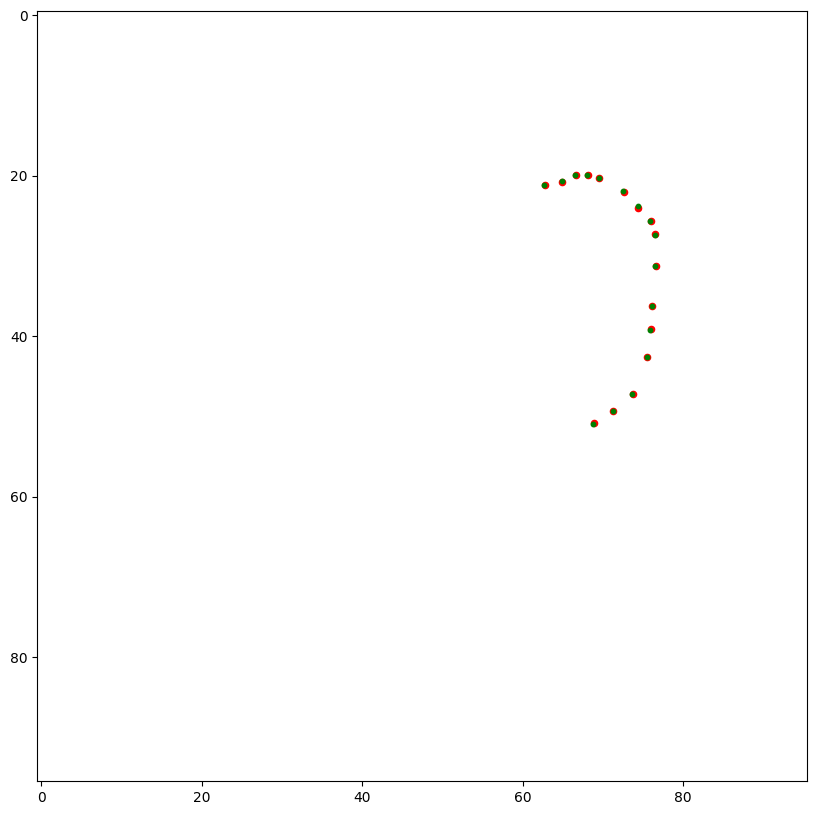

In [32]:
model.eval()
ema_model = ema.averaged_model
ema_model.eval()
with torch.no_grad():
    overfit_batch["image"] = overfit_batch["image"] * 255
    pred = ema_model.predict_action(overfit_batch)
    loss = ema_model.compute_loss(overfit_batch)
    pred = pred.cpu().numpy()
    action = overfit_batch['action'].cpu().numpy()
    agent_pos = overfit_batch['agent_pos'].cpu().numpy()


img = overfit_batch['image'][0,-1].numpy().transpose(1,2,0) 
pred = unnormalize_data(pred[0], stats['action']) / 512 * 96
action = unnormalize_data(action[0], stats['action']) / 512 * 96
print("pred - action: ", pred - action)
print("pred - action: ", np.abs(pred - action).sum())

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(pred[:,0], pred[:,1], c='r', s=20, label='prediction')
plt.scatter(action[:,0], action[:,1], c='g', s=10, label='gt')
plt.show()

In [48]:
load_pretrained = True
if load_pretrained:
  import wandb
  id = "k3get0hm"
  file_dir = os.path.join("wandb", id)
  os.makedirs(file_dir, exist_ok=True)
  ckptn = wandb.restore('best_model.ckpt', 'felix-herrmann/T-Push/k3get0hm', root=file_dir).name
  ckpt = torch.load(ckptn)
  print(ckpt["model"].keys())
  start_epoch = ckpt['epoch_idx'] + 1
  model.load_state_dict(ckpt['model'])
  model = model.to(device)
  best_loss = ckpt['loss']
  ema_model.load_state_dict(ckpt['ema_model'])
  ema_model = ema_model.to(device)
  optimizer.load_state_dict(ckpt['optimizer'])
  lr_scheduler.load_state_dict(ckpt['lr_scheduler'])
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")

odict_keys(['vis_backbone.conv1.weight', 'vis_backbone.bn1.weight', 'vis_backbone.bn1.bias', 'vis_backbone.bn1.running_mean', 'vis_backbone.bn1.running_var', 'vis_backbone.bn1.num_batches_tracked', 'vis_backbone.conv2.weight', 'vis_backbone.bn2.weight', 'vis_backbone.bn2.bias', 'vis_backbone.bn2.running_mean', 'vis_backbone.bn2.running_var', 'vis_backbone.bn2.num_batches_tracked', 'vis_backbone.conv3.weight', 'vis_backbone.bn3.weight', 'vis_backbone.bn3.bias', 'vis_backbone.bn3.running_mean', 'vis_backbone.bn3.running_var', 'vis_backbone.bn3.num_batches_tracked', 'vis_backbone.layer1.0.conv1.weight', 'vis_backbone.layer1.0.bn1.weight', 'vis_backbone.layer1.0.bn1.bias', 'vis_backbone.layer1.0.bn1.running_mean', 'vis_backbone.layer1.0.bn1.running_var', 'vis_backbone.layer1.0.bn1.num_batches_tracked', 'vis_backbone.layer1.0.conv2.weight', 'vis_backbone.layer1.0.bn2.weight', 'vis_backbone.layer1.0.bn2.bias', 'vis_backbone.layer1.0.bn2.running_mean', 'vis_backbone.layer1.0.bn2.running_var',

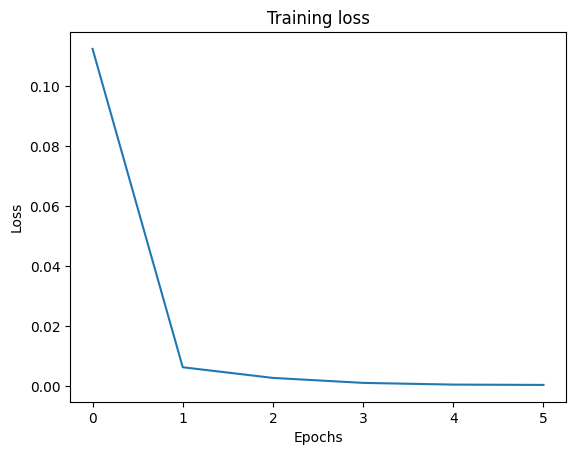

In [ ]:
if not load_pretrained:
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.show()

In [50]:
# limit enviornment interaction to 200 steps before termination
max_steps = 500
env = PushTImageEnv()
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(100000)

# get first observation
obs, info = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
    while not done:
        B = 1
        images = np.stack([x['image'] for x in obs_deque])
        agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

        # normalize observation
        nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
        # images are already normalized to [-1,1]
        nimages = (images * 2 - 1).astype(np.float32)

        # device transfer
        nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32).unsqueeze(0)
        # (1,2,3,96,96)
        nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32).unsqueeze(0)
        # (1,2,2)
        
        obs_dict = {
            'image': nimages,
            'agent_pos': nagent_poses
        }

        # predict action
        with torch.no_grad():
            naction, _ = ema_model.predict_action(obs_dict)
            naction = naction.cpu().numpy()[0]
        
        action_pred = unnormalize_data(naction, stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)

        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from IPython.display import Video
vwrite('vis.mp4', imgs)
Video('vis.mp4', embed=True, width=256, height=256)

Eval PushTImageEnv: 501it [01:18,  6.41it/s, reward=0]                         

Score:  0.0
